<a href="https://colab.research.google.com/github/omrani-wiem/pneumonie-radiographie_/blob/main/radioagraphie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow numpy matplotlib scikit-learn opencv-python


In [ ]:
from google.colab import files
files.upload()


Saving kaggle (1).json to kaggle (1) (1).json


{'kaggle (1) (1).json': b'{"username":"omraniwiem","key":"c222f92e3c4d459f57173d7fe7aa6c65"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp "kaggle (1).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:

!kaggle datasets list -s pneumonia


ref                                                      title                                                      size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-------------------------------------------------------  --------------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
paultimothymooney/chest-xray-pneumonia                   Chest X-Ray Images (Pneumonia)                       2463365435  2018-03-24 19:41:59.603000         565336       7208  0.75             
pcbreviglieri/pneumonia-xray-images                      Pneumonia X-Ray Images                               1225740412  2020-05-18 14:32:09.660000          11828         99  0.9375           
andrewmvd/pediatric-pneumonia-chest-xray                 Pediatric Pneumonia Chest X-ray                      1226136448  2020-03-18 09:11:56.440000           5132         71  0.875            
artyomkolas/3-kinds-of-pneumon

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:

import zipfile

with zipfile.ZipFile("chest-xray-pneumonia.zip", "r") as zip_ref:
    zip_ref.extractall("/content/dataset")

!ls /content/dataset


chest_xray


In [ ]:

!ls /content/dataset/chest_xray
!ls /content/dataset/chest_xray/train
!ls /content/dataset/chest_xray/test
!ls /content/dataset/chest_xray/val


chest_xray  __MACOSX  test  train  val
NORMAL	PNEUMONIA
NORMAL	PNEUMONIA
NORMAL	PNEUMONIA


In [ ]:
import tensorflow as tf

train_dir = "/content/dataset/chest_xray/train"
test_dir = "/content/dataset/chest_xray/test"
val_dir = "/content/dataset/chest_xray/val"

img_height, img_width = 150, 150
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
)


Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import zipfile
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print("TensorFlow version:", tf.__version__)
print("GPUs disponibles :", tf.config.list_physical_devices("GPU"))


DATA_ROOT = "/content/dataset/chest_xray"
TRAIN_DIR = os.path.join(DATA_ROOT, "train")
VAL_DIR   = os.path.join(DATA_ROOT, "val")
TEST_DIR  = os.path.join(DATA_ROOT, "test")


IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15
BASE_MODEL = "efficientnetb0"
OUT_DIR = "/content/outputs"
os.makedirs(OUT_DIR, exist_ok=True)


TensorFlow version: 2.19.0
GPUs disponibles : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
def count_images(folder):
    folder = Path(folder)
    counts = {}
    for cls in sorted([d for d in folder.iterdir() if d.is_dir()]):
        counts[cls.name] = len(list(cls.rglob("*.jpg"))) + len(list(cls.rglob("*.png"))) + len(list(cls.rglob("*.jpeg")))
    return counts

print("Train exists?", os.path.exists(TRAIN_DIR))
print("Val exists? ", os.path.exists(VAL_DIR))
print("Test exists?", os.path.exists(TEST_DIR))

print("\nTrain counts:", count_images(TRAIN_DIR))
print("Val counts:",   count_images(VAL_DIR))
print("Test counts:",  count_images(TEST_DIR))


Train exists? True
Val exists?  True
Test exists? True

Train counts: {'NORMAL': 1341, 'PNEUMONIA': 3875}
Val counts: {'NORMAL': 8, 'PNEUMONIA': 8}
Test counts: {'NORMAL': 234, 'PNEUMONIA': 390}


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

def build_datasets(train_dir, val_dir, test_dir, img_size=IMG_SIZE, batch_size=BATCH_SIZE, augment=True):
    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir, image_size=(img_size,img_size), batch_size=batch_size, shuffle=True
    )
    val_ds = tf.keras.utils.image_dataset_from_directory(
        val_dir, image_size=(img_size,img_size), batch_size=batch_size, shuffle=False
    )
    test_ds = tf.keras.utils.image_dataset_from_directory(
        test_dir, image_size=(img_size,img_size), batch_size=batch_size, shuffle=False
    )

    class_names = train_ds.class_names
    print("Class names:", class_names)


    normalize = layers.Rescaling(1./255)

    if augment:
        data_augmentation = keras.Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.06),
            layers.RandomZoom(0.08),
        ])
    else:
        data_augmentation = None

    def preprocess(x, y, training=False):
        x = normalize(x)
        if training and data_augmentation is not None:
            x = data_augmentation(x, training=True)
        return x, y

    train_ds = train_ds.map(lambda x,y: preprocess(x,y,True), num_parallel_calls=AUTOTUNE)
    val_ds = val_ds.map(lambda x,y: preprocess(x,y,False), num_parallel_calls=AUTOTUNE)
    test_ds = test_ds.map(lambda x,y: preprocess(x,y,False), num_parallel_calls=AUTOTUNE)

    train_ds = train_ds.cache().prefetch(AUTOTUNE)
    val_ds = val_ds.cache().prefetch(AUTOTUNE)
    test_ds = test_ds.cache().prefetch(AUTOTUNE)

    return train_ds, val_ds, test_ds, class_names

train_ds, val_ds, test_ds, class_names = build_datasets(TRAIN_DIR, VAL_DIR, TEST_DIR, augment=True)


Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Class names: ['NORMAL', 'PNEUMONIA']


In [ ]:
from collections import Counter

def compute_class_weights_from_dir(train_dir):
    counts = count_images(train_dir)
    classes = sorted(counts.keys())
    total = sum(counts.values())
    n_classes = len(classes)
    weights = {}
    for i, cls in enumerate(classes):
        weights[i] = total / (n_classes * max(counts[cls], 1))
    return weights, classes, counts

class_weights, classes_ordered, counts = compute_class_weights_from_dir(TRAIN_DIR)
print("Class weights:", class_weights)
print("Classes order:", classes_ordered)
print("Counts:", counts)


Class weights: {0: 1.9448173005219984, 1: 0.6730322580645162}
Classes order: ['NORMAL', 'PNEUMONIA']
Counts: {'NORMAL': 1341, 'PNEUMONIA': 3875}


In [ ]:
from tensorflow.keras import backend as K

def build_model(img_size=IMG_SIZE, base_name="efficientnetb0", dropout_rate=0.3, lr=1e-3, freeze_backbone=True):
    input_shape = (img_size, img_size, 3)
    if base_name.lower() == "efficientnetb0":
        base_model = keras.applications.EfficientNetB0(include_top=False, input_shape=input_shape, weights="imagenet")
        last_conv_name = "top_conv"
        preprocess_fn = keras.applications.efficientnet.preprocess_input
    else:
        raise ValueError("Base non prise en charge")

    base_model.trainable = not freeze_backbone

    inputs = keras.Input(shape=input_shape)
    x = layers.Lambda(lambda z: z * 255.0)(inputs)
    x = layers.Lambda(lambda z: preprocess_fn(z))(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy", keras.metrics.AUC(name="auc"), keras.metrics.Precision(name="precision"), keras.metrics.Recall(name="recall")]
    )
    return model, base_model, last_conv_name

model, base_model, last_conv = build_model(freeze_backbone=True)
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
ckpt_path = os.path.join(OUT_DIR, "best_model.keras")
callbacks = [
    keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_auc", mode="max", save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=5, restore_best_weights=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks
)
model.save(os.path.join(OUT_DIR, "final_head_model.keras"))


Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.7776 - auc: 0.8737 - loss: 0.4601 - precision: 0.9276 - recall: 0.7526
Epoch 1: val_auc improved from -inf to 0.96875, saving model to /content/outputs/best_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 117s 504ms/step - accuracy: 0.7779 - auc: 0.8740 - loss: 0.4595 - precision: 0.9278 - recall: 0.7531 - val_accuracy: 0.8750 - val_auc: 0.9688 - val_loss: 0.3403 - val_precision: 0.8000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8966 - auc: 0.9667 - loss: 0.2503 - precision: 0.9692 - recall: 0.8878
Epoch 2: val_auc improved from 0.96875 to 1.00000, saving model to /content/outputs/best_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8966 - auc: 0.9667 - loss: 0.2502 - precision: 0.9692 - recall: 0.8878 - val_accuracy: 0.8750 - val_auc: 1.0000 - val_loss: 0.2743 - val_precision: 0.8000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/1

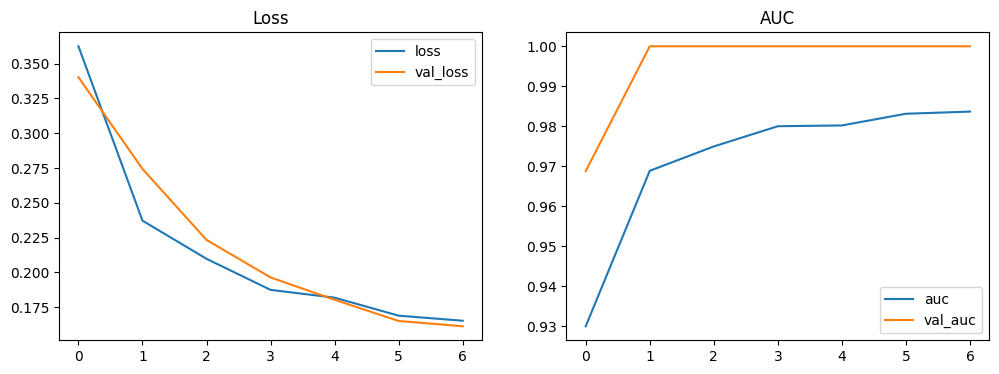

In [ ]:
hist = history.history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist.get("loss",[]), label="loss")
plt.plot(hist.get("val_loss",[]), label="val_loss")
plt.legend(); plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(hist.get("auc",[]), label="auc")
plt.plot(hist.get("val_auc",[]), label="val_auc")
plt.legend(); plt.title("AUC")
plt.show()


In [ ]:
base_model.trainable = True
total = len(base_model.layers)
freeze_until = int(total * 0.7)
for layer in base_model.layers[:freeze_until]:
    layer.trainable = False
for layer in base_model.layers[freeze_until:]:
    layer.trainable = True
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.AUC(name="auc"), keras.metrics.Precision(name="precision"), keras.metrics.Recall(name="recall")]
)

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    class_weight=class_weights,
    callbacks=callbacks
)
model.save(os.path.join(OUT_DIR, "final_finetuned_model.keras"))


Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8373 - auc: 0.9570 - loss: 0.3331 - precision: 0.9808 - recall: 0.7942
Epoch 1: val_auc did not improve from 1.00000
163/163 ━━━━━━━━━━━━━━━━━━━━ 53s 100ms/step - accuracy: 0.8373 - auc: 0.9570 - loss: 0.3329 - precision: 0.9809 - recall: 0.7943 - val_accuracy: 0.8750 - val_auc: 0.9688 - val_loss: 0.2953 - val_precision: 1.0000 - val_recall: 0.7500 - learning_rate: 1.0000e-05
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9038 - auc: 0.9790 - loss: 0.2306 - precision: 0.9887 - recall: 0.8793
Epoch 2: val_auc did not improve from 1.00000
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.9038 - auc: 0.9790 - loss: 0.2305 - precision: 0.9887 - recall: 0.8794 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.2227 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 1.0000e-05
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9247 - auc: 0.9854 - loss: 0.1852 - precision:

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Classes: ['NORMAL', 'PNEUMONIA']
Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 71s 99ms/step - accuracy: 0.7503 - auc: 0.7875 - loss: 0.4843 - val_accuracy: 0.8750 - val_auc: 1.0000 - val_loss: 0.3055
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 31s 22ms/step - accuracy: 0.9222 - auc: 0.9719 - loss: 0.2064 - val_accuracy: 0.9375 - val_auc: 1.0000 - val_loss: 0.2199
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.9210 - auc: 0.9760 - loss: 0.1880 - val_accuracy: 0.8750 - val_auc: 1.0000 - val_loss: 0.2718
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.9438 - auc: 0.9852 - loss: 0.1513 - val_accuracy: 0.9375 - val_auc: 0.9922 - val_loss: 0.2210


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



Classification report:
              precision    recall  f1-score   support

      NORMAL     0.9381    0.4530    0.6110       234
   PNEUMONIA     0.7495    0.9821    0.8502       390

    accuracy                         0.7837       624
   macro avg     0.8438    0.7175    0.7306       624
weighted avg     0.8202    0.7837    0.7605       624

Confusion matrix:
 [[106 128]
 [  7 383]]


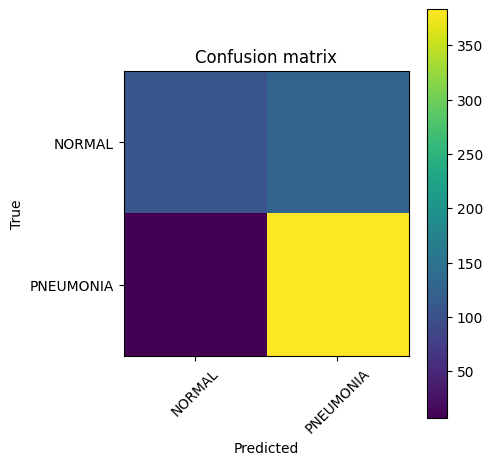

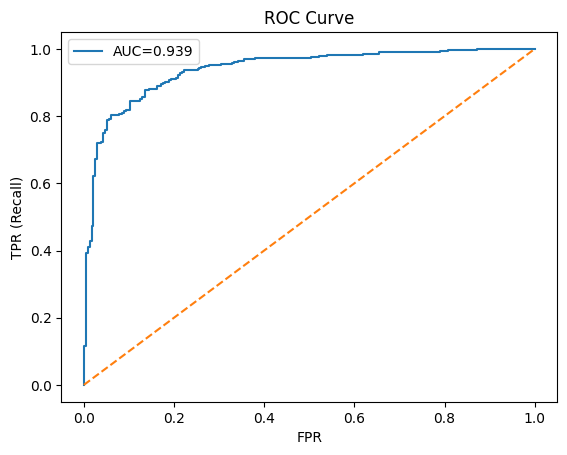

ROC AUC: 0.9389655928117466


In [ ]:

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve


IMG_SIZE = 150
BATCH_SIZE = 32
OUT_DIR = "/content/outputs"
os.makedirs(OUT_DIR, exist_ok=True)

train_dir = "/content/dataset/chest_xray/train"
val_dir = "/content/dataset/chest_xray/val"
test_dir = "/content/dataset/chest_xray/test"


from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess

def preprocess_for_efficientnet(x, y):
    x = tf.cast(x, tf.float32)
    x = eff_preprocess(x)
    return x, y

def make_dataset(dir_path, shuffle=True):
    ds = tf.keras.utils.image_dataset_from_directory(
        dir_path,
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE
    )
    class_names = ds.class_names
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(preprocess_for_efficientnet, num_parallel_calls=tf.data.AUTOTUNE)
    return ds.prefetch(tf.data.AUTOTUNE), class_names

train_ds, class_names = make_dataset(train_dir, shuffle=True)
val_ds, _ = make_dataset(val_dir, shuffle=False)
test_ds, _ = make_dataset(test_dir, shuffle=False)

print("Classes:", class_names)


def build_model(img_size=IMG_SIZE, dropout_rate=0.3, lr=1e-3, freeze_backbone=True):
    input_shape = (img_size, img_size, 3)
    base_model = keras.applications.EfficientNetB0(
        include_top=False, input_shape=input_shape, weights="imagenet"
    )
    base_model.trainable = not freeze_backbone

    inputs = keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(lr),
        loss="binary_crossentropy",
        metrics=["accuracy", keras.metrics.AUC(name="auc")]
    )
    return model


ckpt_weights = os.path.join(OUT_DIR, "best_weights.weights.h5")

model = build_model()
callbacks = [
    keras.callbacks.ModelCheckpoint(
        ckpt_weights, monitor="val_auc", save_best_only=True, save_weights_only=True
    ),
    keras.callbacks.EarlyStopping(monitor="val_auc", patience=3, restore_best_weights=True)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=callbacks
)


best_model = build_model()
best_model.load_weights(ckpt_weights)


y_true, y_prob = [], []

for x_batch, y_batch in test_ds:
    preds = best_model.predict(x_batch, verbose=0)
    y_prob.extend(preds.reshape(-1).tolist())
    y_true.extend(y_batch.numpy().tolist())

y_true = np.array(y_true)
y_prob = np.array(y_prob)
y_pred = (y_prob >= 0.5).astype(int)

print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)


plt.figure(figsize=(5,5))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "confusion_matrix.png"))
plt.show()


auc = roc_auc_score(y_true, y_prob)
fpr, tpr, thr = roc_curve(y_true, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1],"--")
plt.xlabel("FPR")
plt.ylabel("TPR (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.savefig(os.path.join(OUT_DIR, "roc_curve.png"))
plt.show()
print("ROC AUC:", auc)


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

thresholds = np.linspace(0.0, 1.0, 101)
best_t = 0.5
best_f1 = 0.0
for t in thresholds:
    y_pred_t = (y_prob >= t).astype(int)
    f1 = f1_score(y_true, y_pred_t)
    if f1 > best_f1:
        best_f1 = f1
        best_t = t
print(f"Best threshold by F1: {best_t:.3f} → F1={best_f1:.4f}")


Best threshold by F1: 0.850 → F1=0.9035


In [ ]:

import cv2
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras import layers
import os

IMG_SIZE = 150
OUT_DIR = "/content/outputs"
os.makedirs(OUT_DIR, exist_ok=True)
test_dir = "/content/dataset/chest_xray/test"


def load_img_array(path, img_size=IMG_SIZE):
    img = keras.utils.load_img(path, target_size=(img_size, img_size))
    arr = keras.utils.img_to_array(img)
    arr = preprocess_input(arr)
    return np.expand_dims(arr, axis=0)

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )


    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if predictions.shape[-1] == 1:
            loss = predictions[:, 0]
        else:
            loss = predictions[:, tf.argmax(predictions[0])]


    grads = tape.gradient(loss, conv_outputs)


    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))


    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(conv_outputs, pooled_grads), axis=-1)


    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def overlay_and_save(original_img_path, heatmap, out_path, alpha=0.4):
    img = cv2.imread(original_img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(heatmap, alpha, img, 1-alpha, 0)
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.imshow(img); plt.axis('off'); plt.title("Original")
    plt.subplot(1,2,2); plt.imshow(overlay); plt.axis('off'); plt.title("Grad-CAM")
    plt.savefig(out_path, dpi=160)
    plt.show()


best_model.summary()


last_conv_layer_name = None
for layer in best_model.layers:
    if 'conv' in layer.name and isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        print(f"Found convolutional layer: {layer.name}")


if last_conv_layer_name is None:
    for layer in best_model.layers:
        if hasattr(layer, 'layers'):
            for sublayer in layer.layers:
                if 'conv' in sublayer.name and isinstance(sublayer, tf.keras.layers.Conv2D):
                    last_conv_layer_name = f"{layer.name}/{sublayer.name}"
                    print(f"Found convolutional layer in submodel: {last_conv_layer_name}")


if last_conv_layer_name is None:
    last_conv_layer_name = "top_conv"

print(f"Using layer: {last_conv_layer_name} for Grad-CAM")


sample_dir = os.path.join(test_dir, "PNEUMONIA")
sample_files = list(Path(sample_dir).glob("*.jpeg"))[:4]

for i, p in enumerate(sample_files):
    try:
        img_array = load_img_array(str(p))
        heatmap = make_gradcam_heatmap(img_array, best_model, last_conv_layer_name)
        outp = os.path.join(OUT_DIR, f"gradcam_{i}.png")
        overlay_and_save(str(p), heatmap, outp)
        print("Saved:", outp)
    except Exception as e:
        print(f"Error processing {p}: {e}")

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 5, 5, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Found convolutional layer in submodel: efficientnetb0/stem_conv
Found convolutional layer in submodel: efficientnetb0/block1a_project_conv
Found convolutional layer in submodel: efficientnetb0/block2a_expand_conv
Found convolutional layer in submodel: efficientnetb0/block2a_project_conv
Found convolutional layer in submodel: efficientnetb0/block2b_expand_conv
Found convolutional layer in submodel: efficientnetb0/block2b_project_conv
Found convolutional layer in submodel: efficientnetb0/block3a_expand_conv
Found convolutional layer in submodel: efficientnetb0/block3a_project_conv
Found convolutional layer in submodel: efficientnetb0/block3b_expand_conv
Found convolutional layer in submodel: efficientnetb0/block3b_project_conv
Found convolutional layer in submodel: efficientnetb0/block4a_expand_conv
Found convolutional layer in submodel: efficientnetb0/block4a_project_conv
Found convolutional layer in submodel: efficientnetb0/block4b_expand_conv
Found convolutional layer in submodel: eff

In [ ]:

!pip install -q gradio

import gradio as gr

def predict_image(img):

    arr = np.array(img).astype("float32") / 255.0
    arr = cv2.resize(arr, (IMG_SIZE, IMG_SIZE))
    inp = np.expand_dims(arr, axis=0)
    prob = float(best_model.predict(inp)[0,0])
    return {"prob_malade": prob, "prob_sain": 1-prob}

demo = gr.Interface(fn=predict_image, inputs=gr.Image(type="pil"), outputs=[gr.Label(num_top_classes=2)])
demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c8e94009b99b908ab4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
